## Processing handwritten equation with OpenCV and pytesseract

The goal of this project is to make an app which would be able to detect handwritten math symbols on a picture. After detecting math symbols the app should be able to solve simple mathematical problem given on a picture (addition, subtraction, multiplication and divison).

In [1]:
# import useful libraries
import os
import re
import cv2
import pytesseract
import numpy as np
from sympy import *
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
# path to the main dataset directory
main_path = Path('D:\FormulaDecoder\sample_pics')
file_paths = []

# iterate through all files in the folder
for file_path in main_path.glob('**/*'):
    if file_path.is_file():
        file_paths.append(str(file_path))

# print the list of file paths
print(file_paths)

['D:\\FormulaDecoder\\sample_pics\\1.png', 'D:\\FormulaDecoder\\sample_pics\\10.png', 'D:\\FormulaDecoder\\sample_pics\\11.png', 'D:\\FormulaDecoder\\sample_pics\\2.png', 'D:\\FormulaDecoder\\sample_pics\\3.png', 'D:\\FormulaDecoder\\sample_pics\\4.png', 'D:\\FormulaDecoder\\sample_pics\\5.png', 'D:\\FormulaDecoder\\sample_pics\\6.png', 'D:\\FormulaDecoder\\sample_pics\\7.png', 'D:\\FormulaDecoder\\sample_pics\\8.png', 'D:\\FormulaDecoder\\sample_pics\\9.png']


In [ ]:
for sample in file_paths:
    # read image
    img = cv2.imread(sample)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # read characters with pytesseract
    ocr_result = pytesseract.image_to_string(img)
    ocr =  parsing_equation_string(ocr_result)
    print(ocr)
    
    # convert the image to PNG format
    ret, png = cv2.imencode('.png', img)
    
    # display image to check if OCR is correct
    display(Image(data=png))
    
    # Define the input equation as a string
    equation_str = ocr_result[:-2]

    # Convert the equation string to a SymPy expression
    equation = sympify(equation_str)

    # Evaluate the equation
    math_result = equation.evalf()
    
    # Print the result
    print(math_result)

Now, while we are currently capable of solving basic mathematical operations such as addition, division, subtraction, and multiplication, our desire to tackle more intricate tasks and functions continues to drive further development

In [ ]:
# function for loading equation image

def load_image(path):
     """Loads image
    Args:
        path (str): path to image """
        
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    return img

In [3]:
def find_contours(path):
    """
    Finds all contours in a given picture.
    Args:
        path (str): path to image
    Returns:
        contours: Detected contours. Each contour is stored as a vector of points.
        hierarchy: Optional output vector, containing information about the image topology.
    """
    img = cv2.imread(path)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 100, 255, 0)
    return cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def check_exponent(bounding_boxes):
    """Checks difference between vertical coordinate y among two bounding boxes.
    Args:
        bounding_boxes (list): bounding box to be used for comparison
    Returns:
        boolean: True if according to a condition exponent is recognized. Otherwise returns False."""
    
    main_anchor = bounding_boxes[0][1] + bounding_boxes[0][3]
    remaining_anchors = [(bounding_box[1]+bounding_box[3]) for bounding_box in bounding_boxes[1:]]
    
    mask = [False]
    
    is_exponent = None
    delta_y = None
    
    for anchor in remaining_anchors:
        
        if 0.3 < (anchor/main_anchor) < 0.7:
            is_exponent = True
        else:
            is_exponent = False
            
        mask.append(is_exponent)
        
    return mask

In [ ]:
def parsing_equation_string(string): 
    """Parsing string equation on every equation element and saving it into list
    Args:
        string (str): equation string for parsing
    Returns:
        result (lst) : list of equation elements in sequential order
    """
    import re 
    
    # create a regular expression pattern to match numbers and mathematical operators
    pattern = r'(\d+|[+\-*/])'

    # find all matches of the pattern in the string and store the results in a list
    result = re.findall(pattern, string)
    
    return result

In [11]:
def overlapping_axes(coord1, delta1, coord2, delta2):
    """Checks wether 2 bounding boxes overlap over given axes
    Args:
        coord1 (int): start coordinate of axes for first bounding box
        delta1 (int): size of first bounding box along axes
        coord2 (int): coordinate of start axes for second bounding box
        delta2 (int): size of second bounding box along axes
    Returns:
        bool: true if they overlap else false
    """
    if coord1 <= coord2 + delta2 and coord1 >= coord2:
        return True
    if coord1 + delta1 <= coord2 + delta2 and coord1 + delta1 >= coord2:
        return True
    if coord2 <= coord1 + delta1 and coord2 >= coord1:
        return True
    if coord2 + delta2 <= coord1 + delta1 and coord2 + delta2 >= coord1:
        return True

    return False

In [12]:
def remove_overlapping_bounding_boxes(boundingRects):
    """Finds all contours and chooses ones that best contour given characters.
    Args:
        boundingRects (list): list of bounding boxes to check and remove if overlapping
    Returns:
        list: list of bounding boxes for filtered contours
    """

    # If 2 bounding boxes are overlapping, take the bigger one
    for i in range(len(boundingRects)):
        if boundingRects[i] is None:
            continue
        for j in range(i + 1, len(boundingRects)):
            if boundingRects[j] is None:
                continue
            x1, y1, width1, height1 = boundingRects[i]
            x2, y2, width2, height2 = boundingRects[j]

            if overlapping_axes(x1, width1, x2, width2) and overlapping_axes(y1, height1, y2, height2):
                if width1 * height1 > width2 * height2:
                    boundingRects[j] = None
                else:
                    boundingRects[i] = None
                    break

    return [bounding for bounding in boundingRects if bounding is not None]

[(22, 31, 22, 31), (57, 35, 21, 22), (92, 31, 21, 31), (126, 39, 20, 7), (126, 48, 20, 6)]
[False, False, False, False, False]


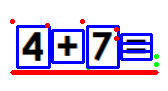

[(64, 83, 104, 179), (198, 50, 78, 119)]
[False, True]


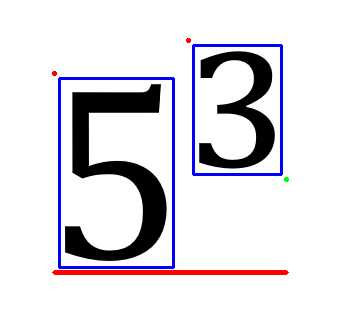

[(16, 44, 29, 32), (52, 26, 12, 17), (84, 54, 38, 5), (134, 27, 33, 48), (170, 44, 34, 32), (209, 16, 16, 18), (224, 38, 3, 3), (246, 37, 38, 38), (303, 44, 23, 32), (344, 37, 38, 38), (396, 27, 31, 49), (444, 47, 38, 5), (444, 60, 38, 6), (499, 27, 31, 49)]
[False, True, False, False, False, True, True, False, False, False, False, False, False, False]


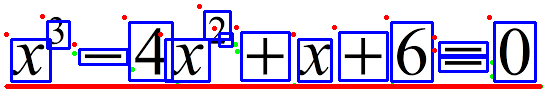

[(36, 37, 20, 30), (69, 41, 21, 22), (103, 37, 22, 31), (138, 45, 21, 7), (138, 54, 21, 6)]
[False, False, False, False, False]


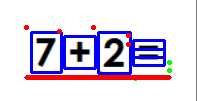

[(33, 37, 21, 30), (68, 41, 21, 21), (102, 37, 21, 30), (137, 44, 20, 7), (137, 53, 20, 7)]
[False, False, False, False, False]


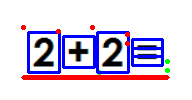

[(34, 37, 20, 30), (68, 41, 21, 21), (105, 37, 13, 30), (137, 44, 21, 7), (137, 53, 21, 7)]
[False, False, False, False, False]


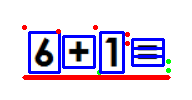

[(35, 36, 20, 31), (69, 40, 21, 22), (103, 36, 22, 31), (138, 44, 20, 7), (138, 53, 20, 6)]
[False, False, False, False, False]


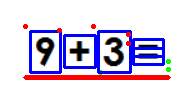

[(35, 36, 21, 31), (69, 40, 21, 22), (103, 36, 22, 31), (138, 44, 21, 7), (138, 53, 21, 6)]
[False, False, False, False, False]


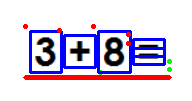

[(18, 23, 32, 47), (54, 23, 32, 47), (107, 31, 31, 32), (160, 23, 31, 48), (196, 23, 30, 47), (248, 51, 31, 6), (249, 38, 30, 6)]
[False, False, False, False, False, False, False]


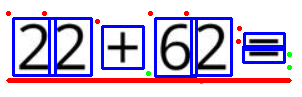

[(30, 36, 31, 48), (66, 36, 31, 47), (101, 37, 35, 46), (155, 45, 31, 31), (207, 36, 31, 47), (244, 36, 31, 48), (280, 36, 31, 48), (333, 51, 30, 6), (333, 64, 30, 5)]
[False, False, False, False, False, False, False, False, False]


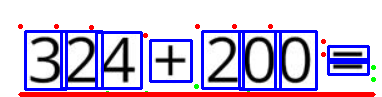

[(10, 32, 59, 87), (71, 18, 39, 51)]
[False, True]


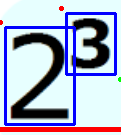

In [42]:
for sample in file_paths:
    
    img = cv2.imread(sample)
    contours, hierarchy = find_contours(sample)
    # create list of tuples
    boundingRects = [cv2.boundingRect(contour) for contour in contours]
    # sort list of tuples by first element (which is x coordinate), that way we get bounding boxes in right order 
    boundingRects.sort()
    boundingRects = boundingRects[1:]
    
    boundingBoxes_filtered = remove_overlapping_bounding_boxes(boundingRects)
    boundingBoxes_filtered = remove_overlapping_bounding_boxes(boundingBoxes_filtered)
    print(boundingBoxes_filtered)
    
 
    exponent = check_exponent_2(boundingBoxes_filtered)
    print(exponent)
    
    (xb,yb,wb,hb)=boundingBoxes_filtered[0]
    (xe,ye,we,he)=boundingBoxes_filtered[-1]
    
    for boundingRect in boundingBoxes_filtered:
        (x,y,w,h)=boundingRect
        cv2.rectangle(img, (x-5, y-5), (x+w+5, y+h+5), (255, 0, 0), 2) # BLUE
        cv2.circle(img,(x-10,y-10),1,(0, 0, 255),2) # RED
        cv2.circle(img,(x+w+10,y+h+10),1,(0, 255, 0),2) # GREEN
    
    #cv2.line(image, start_point, end_point, color, thickness)
    baseline = cv2.line(img,(xb-10,yb+hb+10),(xe+we+10,yb+hb+10),(0, 0, 255),4) # RED LINE
    # show the image with bounding boxes
    ret, png = cv2.imencode('.png', img)
    # display image to check if OCR is correct
    display(Image(data=png))



In [39]:
def check_exponent_2(bounding_boxes):
    """Checks difference between vertical coordinate y among two bounding boxes.
    Args:
        bounding_boxes (list): bounding box to be used for comparison
    Returns:
        boolean: True if according to a condition exponent is recognized. Otherwise returns False."""
    
    origin = (bounding_boxes[0][1])-10
    baseline = bounding_boxes[0][1]+bounding_boxes[0][3]+10
    remaining_anchors = [((bounding_box[1]+bounding_box[3]+10),bounding_box[2],bounding_box[3]) for bounding_box in bounding_boxes[1:]]
    mask = [False]
    
    is_exponent = None
    
    for anchor,w,h in remaining_anchors:
        
        if ((anchor-origin)/(baseline-origin) < 0.65 ) and (w/h < 1.2):
            is_exponent = True
        else:
            is_exponent = False
            
        mask.append(is_exponent)
        
    return mask
